<a href="https://colab.research.google.com/github/EAkeweje/Accelerating-Hydrogen-Oxidation-Calculations/blob/main/FNN_Training_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
from sklearn.metrics import r2_score
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchsummary import summary

import os
import sys

## Utils and Networks

In [ ]:
#get utils

sys.path.append(os.getcwd()+'/scripts')
import Utils as ut

In [ ]:
class net(nn.Module):
  def __init__(self, config):
    super(net, self).__init__()
    self.in_dim, self.out_dim = config['input_size'], config['output_size']
    self.nhid = config['num_layers']
    self.hid_dims = config['hidden_size']

    self.in_layer = nn.Linear(self.in_dim, self.hid_dims[0])
    current_dim = self.hid_dims[0]
    self.hid_layers = nn.ModuleList()
    for i in range(self.nhid-1):
      self.hid_layers.append(nn.Linear(current_dim, self.hid_dims[1]))
      current_dim = self.hid_dims[1]
    self.hid_layers.append(nn.Linear(current_dim, self.hid_dims[0]))
    self.out_layer = nn.Linear(self.hid_dims[0], self.out_dim)
    self.relu = nn.ReLU()
    self.in_batchnorm = nn.BatchNorm1d(self.hid_dims[0])
    self.hid_batchnorm = nn.BatchNorm1d(self.hid_dims[1])
    self.out_batchnorm = nn.BatchNorm1d(self.hid_dims[0])
    self.dropout = nn.Dropout(p = config['dropout'])

  def forward(self, x):
    #pass input to input layer
    out = self.in_batchnorm(self.relu(self.in_layer(x)))
    #pass through hidden layers
    for i in range(self.nhid-1):
      out = self.hid_batchnorm(self.relu(self.hid_layers[i](self.dropout(out))))
    out = self.out_batchnorm(self.relu(self.hid_layers[-1](self.dropout(out))))
    #pass to output layer
    out = self.out_layer(self.dropout(out))

    return out
    
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.kaiming_uniform_(m.weight, nonlinearity= 'relu')
    m.bias.data.fill_(0.0)

## Hyperparameters

In [ ]:
# Config
config = dict(
    ## data
    batch_size = 128,
    dropout = 0.,
    timesteps = [-1],
    nsample = 1500,
    split = [0.7, 0.2, 0.1],
    mean_std_path = "ConcInputs_NoH2O2(taraget_only)_NoPressure_mean_std_laststep.json",
    in_h2_o2 = True,
    in_conc = True,
    in_pres = False,
    out_h2_o2 = False,
    inputs_path = "input_98660.npy",
    outputs_dir = "./Out_files_npy",
    ## model
    input_size = 9,
    hidden_size = [32, 256],
    num_layers = 2,
    output_size = 7,
    ntimesteps = 5,
    ## training
    epochs = 3000,
    optimizer = 'Adam',
    SGD_momentum = 0.95,
    beta1 = 0.95, 
    beta2 = 0.99,
    lr = 0.005,
    dict_path = "./Models/rnn_ConcInputs_NoH2O2(taraget_only)_NoPressure_WANDB_transdata_laststep.pth",
    scheduling = False,
    mb_coeff = 0,
    model = 'FNN',
    weight_decay = 0,
    return_1d_input = True
    )

config

{'batch_size': 128,
 'dropout': 0.0,
 'timesteps': [-1],
 'nsample': 1500,
 'split': [0.7, 0.2, 0.1],
 'mean_std_path': 'ConcInputs_NoH2O2(taraget_only)_NoPressure_mean_std_laststep.json',
 'in_h2_o2': True,
 'in_conc': True,
 'in_pres': False,
 'out_h2_o2': False,
 'inputs_path': 'input_98660.npy',
 'outputs_dir': './Out_files_npy',
 'input_size': 9,
 'hidden_size': [32, 256],
 'num_layers': 2,
 'output_size': 7,
 'ntimesteps': 5,
 'epochs': 3000,
 'optimizer': 'Adam',
 'SGD_momentum': 0.95,
 'beta1': 0.95,
 'beta2': 0.99,
 'lr': 0.005,
 'dict_path': './Models/rnn_ConcInputs_NoH2O2(taraget_only)_NoPressure_WANDB_transdata_laststep.pth',
 'scheduling': False,
 'mb_coeff': 0,
 'model': 'FNN',
 'weight_decay': 0,
 'return_1d_input': True}

# Training

In [ ]:
#hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#data
#prepare dataloaders
train_loader, val_loader, test_loader = ut.make_dataloaders(config)
#obtaining mean and std of training set
if config['mean_std_path']:
  train_x_mean, train_x_std, train_y_mean, train_y_std = ut.load_mean_std(config['mean_std_path'], train_loader)
  mean_std = [train_x_mean.to(device), train_x_std.to(device), train_y_mean.to(device), train_y_std.to(device)]
else:
  mean_std = None
#model
#initialize model
model = net(config)

#training
model = model.to(device)
criterion  = nn.MSELoss()
e, val_loss, train_losses, val_losses = ut.training(model, train_loader, val_loader, config, criterion, mean_std, device)
print('least val loss:', val_loss)

Saving Model... Error at Epoch 1: 1.3037571012973785
Saving Model... Error at Epoch 2: 0.3975156396627426
Saving Model... Error at Epoch 3: 0.1933944784104824
Saving Model... Error at Epoch 4: 0.13447250798344612
Saving Model... Error at Epoch 5: 0.12402111664414406
Saving Model... Error at Epoch 6: 0.07591266185045242
Saving Model... Error at Epoch 7: 0.06469455547630787
Saving Model... Error at Epoch 8: 0.052201876416802406
Saving Model... Error at Epoch 9: 0.048675086349248886
Saving Model... Error at Epoch 10: 0.045178831554949284
Saving Model... Error at Epoch 11: 0.04275891091674566
Saving Model... Error at Epoch 12: 0.03975028917193413
Saving Model... Error at Epoch 13: 0.0315054701641202
Saving Model... Error at Epoch 18: 0.029793644323945045
Saving Model... Error at Epoch 19: 0.029446538537740707
Saving Model... Error at Epoch 21: 0.02602966269478202
Saving Model... Error at Epoch 32: 0.023819122463464737
Saving Model... Error at Epoch 38: 0.022784764412790537
Saving Model... 

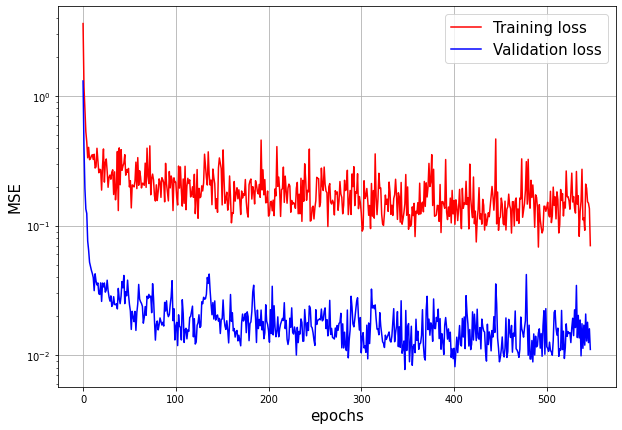

In [ ]:
ut.loss_plot(train_losses, val_losses)

# Inference

In [ ]:
def inf_make_dataloaders(config):
    '''
    batch_size: int = batch size
    ntimesteps: int or list = number/list of time steps in data
    nsample: int = number of samples to use
    split: list = list of train set to data ration and train+valid set to data ratio
    '''
    #initialize dataset object
    dataset = ut.ChemDataset(inputs_path = config['inputs_path'],
                          outputs_dir = config['outputs_dir'],
                          nsample = config['nsample'],
                          ntimesteps = config['timesteps'],
                          in_h2_o2 = True,
                          in_pres= True,
                          in_conc= config['in_conc'],
                          out_h2_o2 = True,
                          return_1d_input = config['return_1d_input'])
    
    # Creating Training, Validation, and Test dataloaders
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_split = int(np.floor(config['split'][0] * dataset_size))
    val_split = int(np.floor(config['split'][1] * dataset_size))
    shuffle_dataset = True
    random_seed = 42
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices = indices[ : train_split]
    val_indices = indices[train_split : train_split + val_split]
    test_indices = indices[train_split + val_split : ]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size = config['batch_size'], sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size = config['batch_size'], sampler=valid_sampler)
    test_loader = DataLoader(dataset, batch_size = config['batch_size'], sampler=test_sampler)
    
    return train_loader, validation_loader, test_loader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#data
#prepare dataloaders
train_loader, val_loader, test_loader = inf_make_dataloaders(config)

#obtaining mean and std of training set
if config['mean_std_path']:
  train_x_mean, train_x_std, train_y_mean, train_y_std = ut.load_mean_std(config['mean_std_path'], train_loader)
  mean_std = [train_x_mean.to(device), train_x_std.to(device), train_y_mean.to(device), train_y_std.to(device)]
else:
  mean_std = None

#model
#initialize model
model = net(config)

#load model parameters
model.load_state_dict(torch.load(config['dict_path'], map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

net(
  (in_layer): Linear(in_features=9, out_features=32, bias=True)
  (hid_layers): ModuleList(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=32, bias=True)
  )
  (out_layer): Linear(in_features=32, out_features=7, bias=True)
  (relu): ReLU()
  (in_batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hid_batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out_batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [ ]:
x,y = next(iter(train_loader))
x.shape

torch.Size([128, 10])

In [ ]:
y[:,1].unsqueeze(dim=0).shape

torch.Size([1, 128])

In [ ]:
##NME
target_stack = []
predict_stack = []

for i, (input, target) in enumerate(test_loader):

  #make prediction
  pred, target = ut.prediction(model, input, target, config, mean_std, device)

  #save prediction
  predict_stack.append(pred)
  target_stack.append(target)

error = torch.linalg.norm(torch.concat(target_stack) - torch.concat(predict_stack))/torch.linalg.norm(torch.concat(target_stack))
print(f'Normalized Error: {error}')

Normalized Error: 0.0022431771001778706


In [ ]:
torch.concat(target_stack).shape

torch.Size([150, 9])

In [ ]:
r2_score(torch.concat(target_stack).flatten().detach().cpu().numpy(), torch.concat(predict_stack).flatten().detach().cpu().numpy())

0.9999943230868181

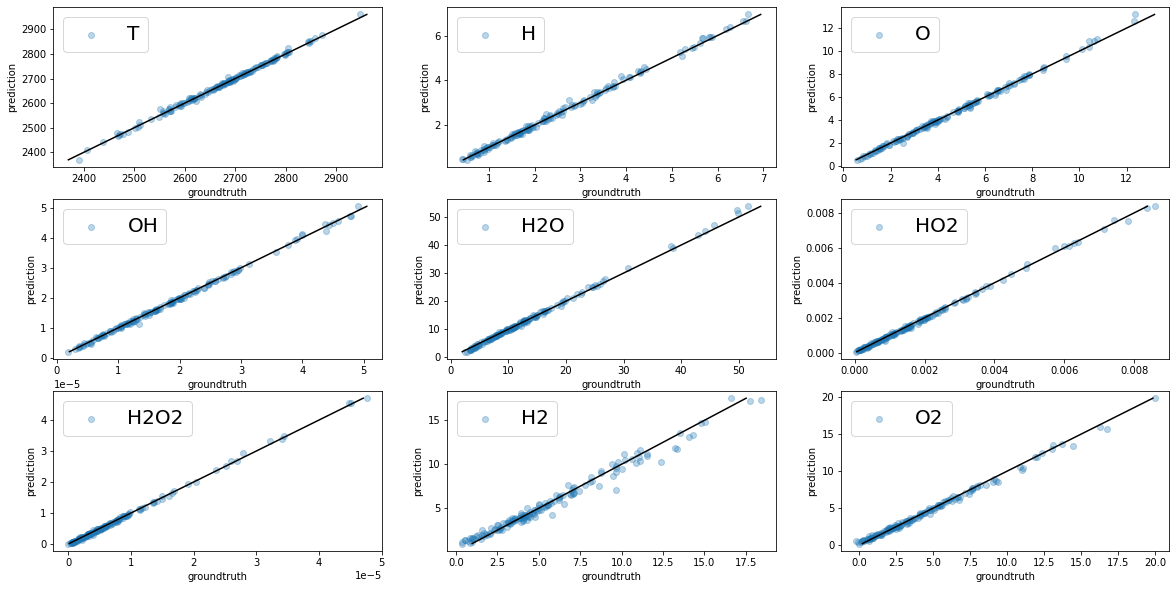

In [ ]:
ut.show_results(torch.concat(predict_stack), torch.concat(target_stack), 138, True)

### Inference on external **data**

In [ ]:
def return_conc(input):
  #compute total amount of all gases
  total_amount_all = ut.get_total_material(input[-2], input[-1])
  #compute concentrations
  concs = input[:-2]*total_amount_all #c_i = x_i * \nu
  input = torch.concat((concs, input[-2:]))
  return input

In [ ]:
input = torch.tensor([0.258059, 0.076098, 0.079991, 0.406154, 0.050154, 0.129445, 0.000035, 0.000065, 552392, 2869])
if config['in_conc']:
  input = return_conc(input)
input = input[None, :]
target =  torch.from_numpy(np.loadtxt('./Out_files_197/out0.txt', delimiter= ';')[config['timesteps'], 1:-2])

pred, target = ut.prediction(model, input, target, config, mean_std, device)
error = torch.linalg.norm(target - pred)/torch.linalg.norm(target)
print('Error = ', error.item())

Error =  0.0015895472249611222


In [ ]:
print(pred-target)

tensor([[-4.3248e+00,  6.2207e-02,  3.4467e-02,  2.6194e-02,  4.9250e-01,
          1.2462e-04,  5.3073e-07, -5.3676e-01, -2.7670e-01]], device='cuda:0',
       dtype=torch.float64, grad_fn=<SubBackward0>)


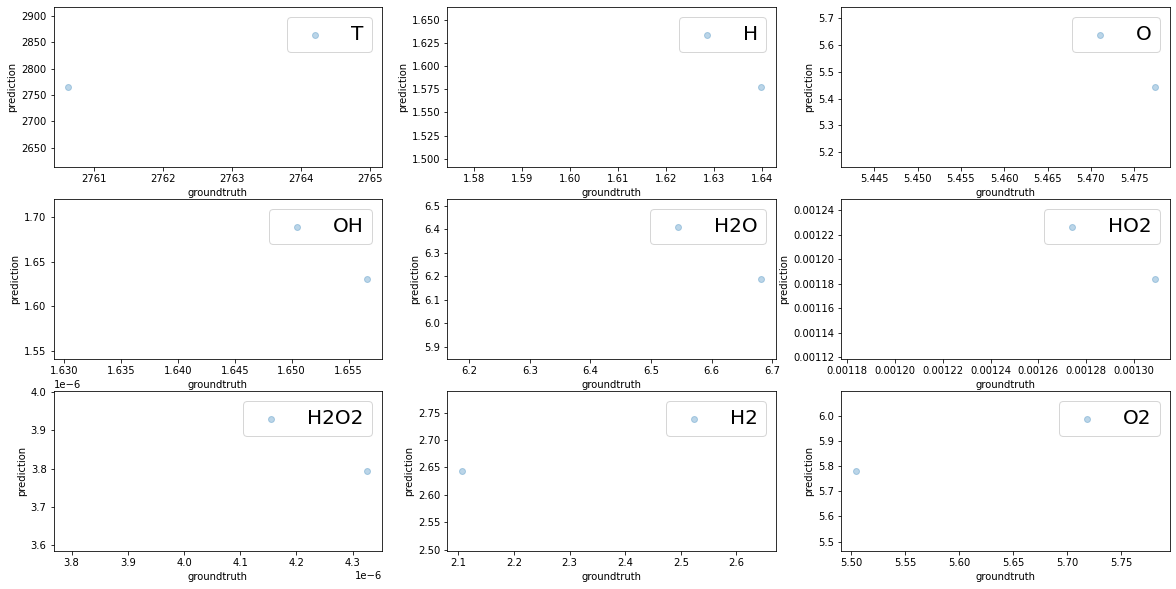

In [ ]:
ut.show_results(pred, target, lastH2O2 = True)

In [ ]:
model.eval()
input = torch.tensor([0.370668, 0.052756, 0.090097, 0.106036, 0.036734, 0.343536, 0.000104, 0.000068, 834259, 2874])
if config['in_conc']:
  input = return_conc(input)
input = input[None, :]
target =  torch.from_numpy(np.loadtxt('./Out_files_197/out10.txt', delimiter= ';')[config['timesteps'], 1:-2])

pred, target = ut.prediction(model, input, target, config, mean_std, device)
error = torch.linalg.norm(target - pred)/torch.linalg.norm(target)
print('Error =', error.item())

Error = 0.0009987189758890128


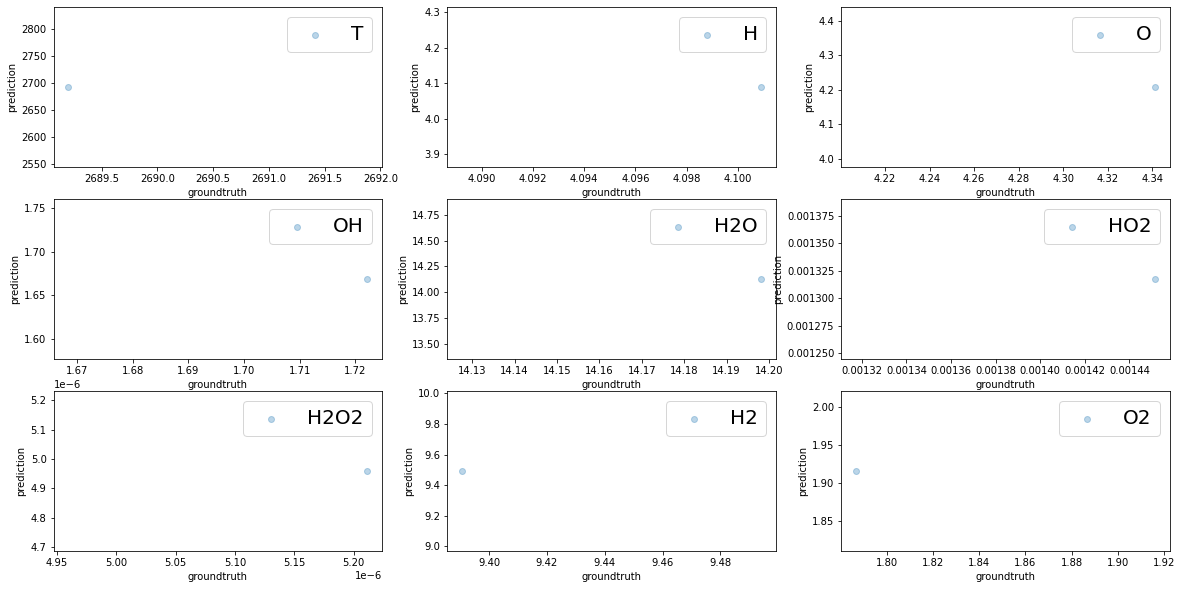

In [ ]:
ut.show_results(pred, target, lastH2O2 = True)

#Comparing performance with model trained on all independent features

In [ ]:
#load predictions of the other model
pred2 = torch.from_numpy(np.load('pred_test.npy'))

if not config['out_h2_o2']:
  #reordering features to match
  C_H2_ = pred2[:, :, 1]
  C_O2_ = pred2[:, :, 4]
  ##Exclude O2 and H2
  pred2_ = np.delete(pred2, [1,4], axis = 2)
  ## Concatenate H2 and O2
  pred2 = torch.concat((pred2_, C_H2_.unsqueeze(dim = 2), C_O2_.unsqueeze(dim = 2)), dim = 2)
  
if config['in_conc']:
  pred2 = pred2[ :,1:,:]

if config['timesteps'] != 'all':
  steps = []
  for i in range(len(config['timesteps'])):
    steps.append(config['timesteps'][i] - 1)
  pred2 = pred2[:, steps, :]
pred2.shape

torch.Size([1, 1, 9])

In [ ]:
def show_plots_3(predict1, predict2, target, lastH2O2= False):
  fig, ax = plt.subplots(3,3, figsize = (20,10))
  if lastH2O2:
    labels = ["T",	'H', 'O',	'OH',	'H2O',	'HO2',	'H2O2', 'H2', 'O2']
  else:
    labels = ["T",	'H2', 'H', 'O', 'O2', 'OH',	'H2O',	'HO2',	'H2O2']

  for i in range(9):
    a,b = i//3, i%3
    A = predict1[0,:,i]
    A_ = predict2[0, :, i]
    A_true = target[0,:,i]
    # ax[a,b].figure()
    ax[a,b].plot(A.detach().cpu(), '-r', label = 'New Model')
    ax[a,b].plot(A_.detach().cpu(), '-b', label = 'All independents')
    ax[a,b].plot(A_true.detach().cpu(), '-g', label = 'groundtruth')
    ax[a,b].set_title(labels[i])
    ax[a,b].legend()
  plt.show()

In [ ]:
show_plots_3(pred, pred2, target, True)